# Cut-offs

There are several cutoffs in Tor Des Geants and they differ by race. 
For this reason, this file will be cleaned and used to assess the cut-offs
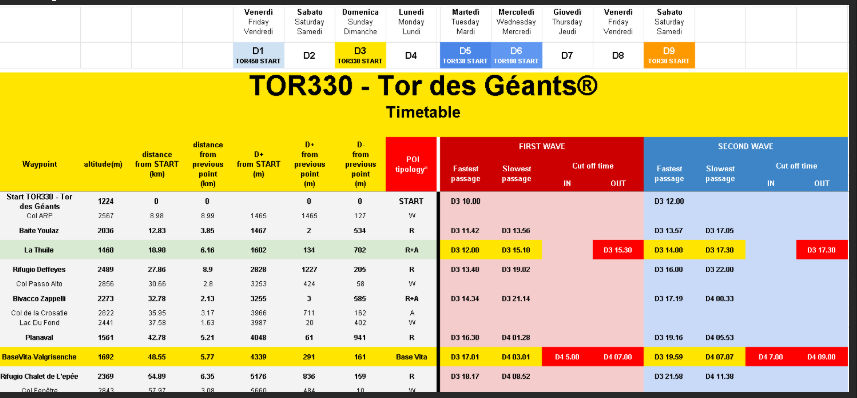

In [1]:
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
year ='2023'
race = 'TOR330'

list_years = ['2021', '2022', '2023', '2024']


In [3]:
# # Set pandas options to display all columns and rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

In [4]:
def cleaning_cut_off_data(df, column, category_order):

    df = df[[ 'Aid Station',  
           'distance\nfrom START\n(km)', 
           'D+\nfrom START (m)', 'Wave1']][
                                (df['Aid Station'].isin(category_order))&
                                (df['Year'] == year)]
    print(df['Aid Station'].unique())
    
    df = df.rename(columns={"Aid Station": column,
                                            "Wave1": "Cut Off Date"})

    # Set f'{column}' as a categorical column with the defined order
    df[column] = pd.Categorical(
        df[column],
        categories=category_order,
        ordered=True
    )
    # Calculate differences
    df[f"{column} Distance (km)"] = df["distance\nfrom START\n(km)"].diff().fillna(0)
    df[f"{column} Elevation Gain (m)"] = df["D+\nfrom START (m)"].diff().fillna(0)
    
    # renaming columns so it is easier later to compare
    df = df.rename(columns={"D+\nfrom START (m)" : f"{column} Accumulated Elevation (m)",\
                            "distance\nfrom START\n(km)" : f"{column} Accumulated Distance Elevation (m)",}) 
    
    df[f"{column} Duration"] = df["Cut Off Date"].diff()
    
    # Convert duration to seconds
    df[f'{column} Duration_seconds'] = pd.to_timedelta( df[f"{column} Duration"], errors='coerce').dt.total_seconds()
    
    df[f'{column}'] = df[f'{column}'].str.replace( 'TORX Finish Line', 'FINISH')
    df= df.reset_index(drop =  True)
    return df

In [5]:
    
def place_into_stage(df, column):
    Stage1 = [ 'Start', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes',\
              'Planaval', 'Valgrisenche IN',]
    Stage2 = [ 'Valgrisenche OUT', 'Chalet Epee',\
              'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN']
    Stage3 = [  'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset','Donnas IN',]
    Stage4 = [  'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda', \
              'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',\
              'Niel La Gruba', 'Loo', 'Gressoney IN', ]
    Stage5 = [  'Gressoney OUT', 'Rifugio Alpenzu', 'Champoluc' ,\
              'Rifugio Grand Tournalin', 'Valtournenche IN' ]
    Stage6 = [   'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',\
              'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace', \
              'Bruson Arp', 'Ollomont IN',]    
    Stage7 = [ 'Ollomont OUT', 'Rifugio Champillon', 'Ponteille Desot',\
              'Bosses', 'Rifugio Frassati', 'Pas Entre Deux Sauts',\
              'Monte de la Saxe', 'FINISH']

    stages =[ Stage1, Stage2, Stage3, Stage4, Stage5, Stage6, Stage7]
    stages_str =[ 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5', 'Stage 6', 'Stage 7']
    for stage,  stage_str in zip(stages, stages_str):
        df.loc[df[column].isin(stage), 'Stage'] = f'{stage_str}'

    lifebase_time_spent = ['Valgrisenche OUT','Cogne OUT','Donnas OUT','Gressoney OUT','Valtournenche OUT','Ollomont OUT']

    for lifebase in lifebase_time_spent:
        lifebase_split = lifebase.split(' OUT')[0] 
        df.loc[df[column] == lifebase, 'Stage'] = f'Time Spent in {lifebase_split}'
        
    return df


In [6]:
def place_in_order(df, column):
    try:
        if column == 'Aid Station':
            # renaming columns so it is easier later to compare
            df = df.rename(columns={"D+\nfrom START (m)" : f"{column} Accumulated Elevation (m)",\
                                    "distance\nfrom START\n(km)" : f"{column} Accumulated Distance Elevation (m)",}) 

            df  = df[[f'{column}', 'Stage',        
                    f'{column} Distance (km)',  f'{column} Accumulated Distance Elevation (m)',
                    f'{column} Elevation Gain (m)',f'{column} Accumulated Elevation (m)',
        #             f'{column} Duration',
                      f'Checkpoint Duration_seconds']] 
        else:
            df = df[~(df[column] == 'Start')]

            df  = df[[f'{column}', 'Stage',        
                    f'{column} Distance (km)',  f'{column} Accumulated Distance Elevation (m)',
                    f'{column} Elevation Gain (m)',f'{column} Accumulated Elevation (m)',
        #             f'{column} Duration',
                      f'{column} Duration_seconds'
                 ]]

    except:
        pass
    return df

### Reading in TORX dates extracted from DUV

In [7]:
file = f'TORX DUV dates/TORX_duv_dates_df.xlsx'
dates_duv_df = pd.read_excel(file)

# Drop the intermediate columns if they're no longer needed
dates_duv_df = dates_duv_df.drop(columns=['Day_of_Week Start_Date']) 
dates_duv_df['Year'] = dates_duv_df['Year'].astype('str')
dates_duv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Race        26 non-null     object        
 1   Year        26 non-null     object        
 2   Start Date  26 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 752.0+ bytes


In [8]:
dates_duv_df[(dates_duv_df['Race'] == 'TOR330') &
             (dates_duv_df['Year'].isin( list_years ))
            ].sort_values(by = 'Year', ascending = False).reset_index(drop = True)

,Race,Year,Start Date
0,TOR330,2024,2024-09-08 10:00:00
1,TOR330,2023,2023-09-10 10:00:00
2,TOR330,2022,2022-09-11 10:00:00
3,TOR330,2021,2021-09-12 10:00:00


In [9]:
dates_duv_df[(dates_duv_df['Race'] == 'TOR450') &
             (dates_duv_df['Year'].isin(list_years))
            ].sort_values(by = 'Year', ascending = False).reset_index(drop = True)

,Race,Year,Start Date
0,TOR450,2024,2024-09-06 20:00:00
1,TOR450,2023,2023-09-08 20:00:00
2,TOR450,2022,2022-09-09 20:00:00
3,TOR450,2021,2021-09-10 20:00:00


In [10]:
dates_duv_df[dates_duv_df['Year'] == year]

,Race,Year,Start Date
1,TOR130,2023,2023-09-12 21:00:00
7,TOR330,2023,2023-09-10 10:00:00
21,TOR450,2023,2023-09-08 20:00:00


In [11]:
# Extract only the date part (YYYY-MM-DD)
TOR450_dates_duv_df = dates_duv_df[(dates_duv_df['Race'] == 'TOR450')]
TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].astype('str')
TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].str.split(' ').str.get(0)
TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].astype('datetime64[D]')

# renaming columns so it is easier later to compare
TOR450_dates_duv_df = TOR450_dates_duv_df.rename(columns={"Start Date": "D1"}) 
n = -1
for day in range(0, 10):
    n = n + 1
    dday = day +1
    TOR450_dates_duv_df[f'D{dday}'] = TOR450_dates_duv_df['D1'] + pd.to_timedelta(f'{day} day')
#     print(n,'\n', day, '\n', TOR450_dates_duv_df[[f'D{dday}']])
    
TOR450_dates_duv_df

C:\Users\Karina\AppData\Local\Temp\ipykernel_20216\3320870364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].astype('str')
C:\Users\Karina\AppData\Local\Temp\ipykernel_20216\3320870364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dates_duv_df['Start Date'] = TOR450_dates_duv_df['Start Date'].str.split(' ').str.get(0)
C:\Users\Karina\AppData\Local\Temp\ipykernel_20216\3320870364.py:5: SettingWithCopyWarning: 
A value is 

,Race,Year,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
21,TOR450,2023,2023-09-08,2023-09-09,2023-09-10,2023-09-11,2023-09-12,2023-09-13,2023-09-14,2023-09-15,2023-09-16,2023-09-17
22,TOR450,2024,2024-09-06,2024-09-07,2024-09-08,2024-09-09,2024-09-10,2024-09-11,2024-09-12,2024-09-13,2024-09-14,2024-09-15
23,TOR450,2022,2022-09-09,2022-09-10,2022-09-11,2022-09-12,2022-09-13,2022-09-14,2022-09-15,2022-09-16,2022-09-17,2022-09-18
24,TOR450,2019,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15
25,TOR450,2021,2021-09-10,2021-09-11,2021-09-12,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19


### Getting dates into CutOffs
but the issue is also D3 looks different every year. So using DUV_dates, I am able to extract the date of the TOR450 (which is D1) and then create a new dataset with each D# to get the correct date for each cut off!

In [12]:
# D# | Date | Year
# D1 | '2023-09-08' | 2023

# Pivot the data using melt
pivoted_TOR450_dates_duv_df = TOR450_dates_duv_df.melt(id_vars=["Race", "Year"], 
                     var_name="D#", 
                     value_name="Date")

# Convert 'Date' to datetime and extract just the date (optional)
pivoted_TOR450_dates_duv_df["Date"] = pd.to_datetime(pivoted_TOR450_dates_duv_df["Date"]).dt.date
pivoted_TOR450_dates_duv_df = pivoted_TOR450_dates_duv_df.drop(columns=['Race'])

# Display the result
# pivoted_TOR450_dates_duv_df[pivoted_TOR450_dates_duv_df['Year'] == 2023].reset_index(drop = True)

### Reading in TOR330 Data on elevation / distance

A copy of the original 'TOR330 - Downloads.xlsx' and 'TOR450 - Downloads.xlsx' and were changed to reflect the downloaded 100x100trail data 


The original Timetable looks like this:
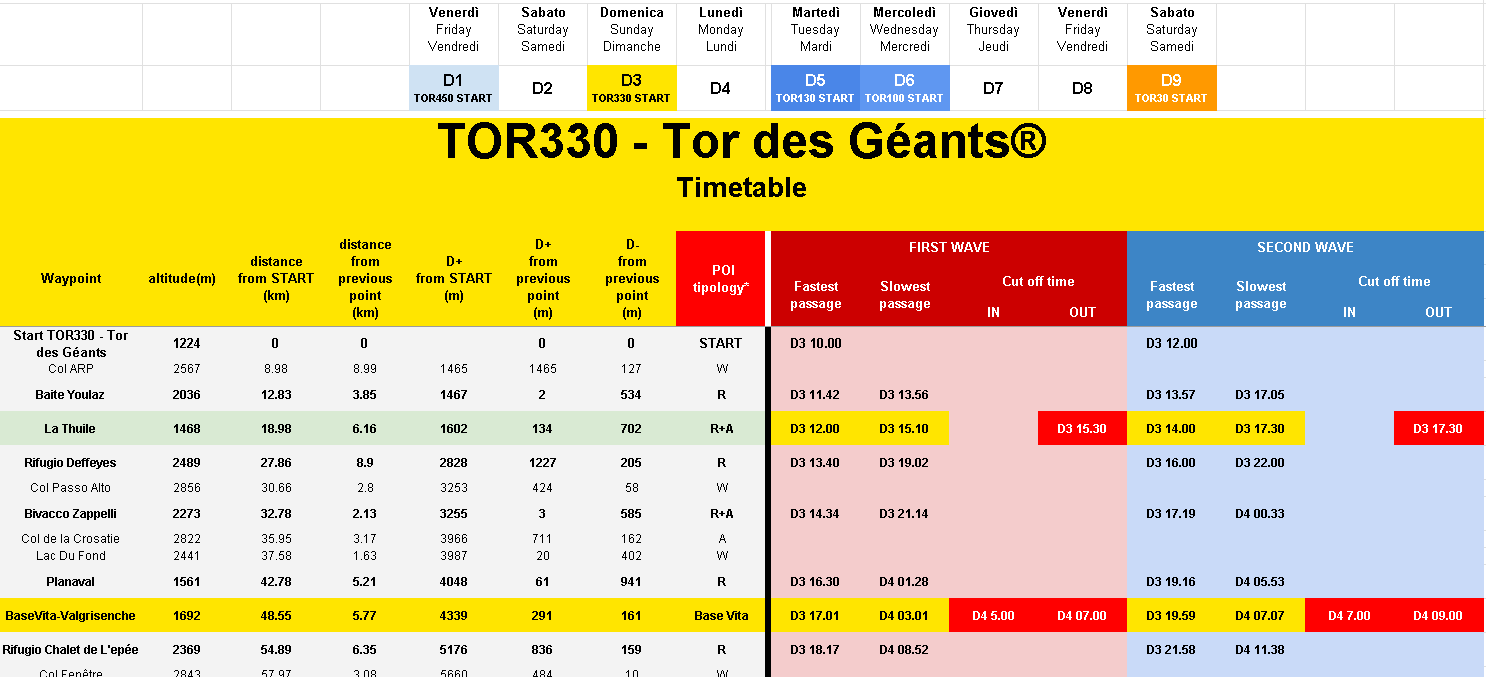

So I cleaned it up by doing this:
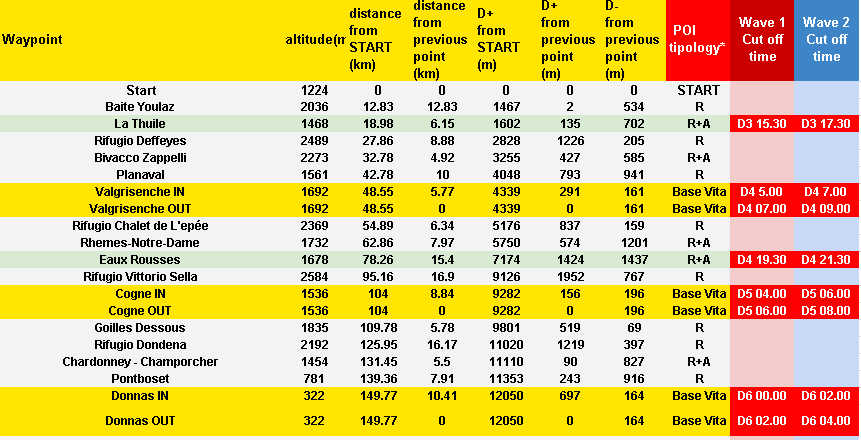

### Reading in the Cut-Offs

In [13]:
TOR330_aid_station_info_df = pd.read_excel('TOR330 Data/4. TOR330 Timetable Data/TOR330 - Timetable.xlsx', sheet_name = 'Sheet1')

# organising the data in the correct order by 'distance\nfrom START\n(km)'
# TOR330_aid_station_info_df = TOR330_aid_station_info_df.sort_values(by ='distance\nfrom START\n(km)')

# getting the list of aid stations
TOR330_aid_station_list= list(TOR330_aid_station_info_df['100X100trail Aid Stations'].unique())

# the aid station is the correct order
TOR330_aid_station_list


['START',
 'Baite Youlaz',
 'La Thuile',
 'Rifugio Deffeyes',
 'Bivacco Zappelli',
 'Planaval',
 'Valgrisenche IN',
 'Valgrisenche OUT',
 'Chalet Epee',
 'Rhemes-Notre-Dame',
 'Eaux Rousse',
 'Rifugio Sella',
 'Cogne IN',
 'Cogne OUT',
 'Goilles',
 'Rifugio Dondena',
 'Chardonney',
 'Pontboset',
 'Donnas IN',
 'Donnas OUT',
 'Perloz',
 'Sassa',
 'Rifugio Coda',
 'Rifugio della Barma',
 'Lago Chiaro',
 'Col della Vecchia',
 'Niel La Gruba',
 'Loo',
 'Gressoney IN',
 'Gressoney OUT',
 'Rifugio Alpenzu',
 'Champoluc',
 'Rifugio Grand Tournalin',
 'Valtournenche IN',
 'Valtournenche OUT',
 'Rifugio Barmasse',
 'Vareton',
 'Rifugio Magià',
 'Rifugio Cuney',
 'Bivacco R. Clermont',
 'Oyace IN',
 'Bruson Arp',
 'Col Brison',
 'Berio Damon',
 'Ollomont IN',
 'Ollomont OUT',
 'Rifugio Champillon',
 'Ponteille Desot',
 'Bosses',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']

In [14]:
TOR330_aid_station_info_df.columns

Index(['100X100trail Aid Stations', 'Waypoint', 'altitude\n(m)',
       'distance\nfrom START\n(km)', 'distance\nfrom previous point\n(km)',
       'D+\nfrom START (m)', 'D+\nfrom previous point\n(m)',
       'D-\nfrom previous point\n(m)', 'POI tipology*', 'Wave 1 Cut off time',
       'Wave 2 Cut off time'],
      dtype='object')

In [15]:
# renaming columns so it is easier later to compare
TOR330_aid_station_info_df = TOR330_aid_station_info_df.rename(columns={"100X100trail Aid Stations": "Aid Station"}) 

TOR330_aid_station_info_df.loc[TOR330_aid_station_info_df['Wave 1 Cut off time'] == 'MID-RACE', 'Wave 1 Cut off time'] = np.nan

# keeping only the rows that are not empty
cutoffs_df = TOR330_aid_station_info_df[['Aid Station',
                                         'Wave 1 Cut off time', 
                                         'distance\nfrom START\n(km)', 
                                         'D+\nfrom START (m)']][
                                            # drop  all rows where Wave 1 Cut off time is empty
                                            ~(TOR330_aid_station_info_df['Wave 1 Cut off time'].isna())]



# Splitting 'D# Time'
cutoffs_df['Wave 1 Cut off Split'] = cutoffs_df['Wave 1 Cut off time'].str.split(' ')

# getting the D#
cutoffs_df['D#'] = cutoffs_df['Wave 1 Cut off Split'].str.get(0)
# getting the cut off time
cutoffs_df['D# Time'] = cutoffs_df['Wave 1 Cut off Split'].str.get(1)
# Replacing  'D3 15.30' with 'D3 15:30'
cutoffs_df['D# Time'] = cutoffs_df['D# Time'].str.replace('.', ':')


cutoffs_df = place_into_stage(cutoffs_df, 'Aid Station')

C:\Users\Karina\AppData\Local\Temp\ipykernel_20216\3891850131.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cutoffs_df['D# Time'] = cutoffs_df['D# Time'].str.replace('.', ':')


In [16]:
cutoffs_df

,Aid Station,Wave 1 Cut off time,distance\nfrom START\n(km),D+\nfrom START (m),Wave 1 Cut off Split,D#,D# Time,Stage
0,START,D3 10.00,0.00,0,"[D3, 10.00]",D3,10:00,NaN
2,La Thuile,D3 15.30,18.98,1602,"[D3, 15.30]",D3,15:30,Stage 1
6,Valgrisenche IN,D4 5.00,48.55,4339,"[D4, 5.00]",D4,5:00,Stage 1
7,Valgrisenche OUT,D4 07.00,48.55,4339,"[D4, 07.00]",D4,07:00,Time Spent in Valgrisenche
10,Eaux Rousse,D4 19.30,78.26,7174,"[D4, 19.30]",D4,19:30,Stage 2
12,Cogne IN,D5 04.00,104.00,9282,"[D5, 04.00]",D5,04:00,Stage 2
13,Cogne OUT,D5 06.00,104.00,9282,"[D5, 06.00]",D5,06:00,Time Spent in Cogne
18,Donnas IN,D6 00.00,149.77,12050,"[D6, 00.00]",D6,00:00,Stage 3
19,Donnas OUT,D6 02.00,149.77,12050,"[D6, 02.00]",D6,02:00,Time Spent in Donnas
23,Rifugio della Barma,D6 13.00,175.79,15512,"[D6, 13.00]",D6,13:00,Stage 4


### Merging new D# Dataset

In [17]:
# # Merging the new D1  dataframe and pivoted_TOR450_dates_duv_df
# cutoffs_df1 = cutoffs_df.merge(
#     pivoted_TOR450_dates_duv_df, 
#     on='D#',
#     how='left')

# cutoffs_df['Aid Station'].unique()

In [18]:

# Merging the new D1  dataframe and pivoted_TOR450_dates_duv_df
cutoffs_df = cutoffs_df.merge(
    pivoted_TOR450_dates_duv_df, 
    on='D#',
    how='left')

# getting the date and the time back together
cutoffs_df['new_Wave 1 Cut off time'] = cutoffs_df['Date'].astype('str') + ' ' + cutoffs_df['D# Time']
# convert the new column in datetime 
cutoffs_df['Wave1'] = pd.to_datetime(cutoffs_df['new_Wave 1 Cut off time'])

# Create a new wave2 which is 2 hours behind
cutoffs_df['Wave2'] = cutoffs_df['Wave1'] + pd.to_timedelta('02:00:00')

# #dropping irrelevant columns
cutoffs_df = cutoffs_df[['Aid Station', 'Year','distance\nfrom START\n(km)', 'D+\nfrom START (m)',  #'Date',
                         'Wave1', 'Wave2']]


cutoffs_df['Aid Station'] = cutoffs_df['Aid Station'].str.replace('Eaux Rousses', 'Eaux Rousse')    
cutoffs_df['Aid Station'] = cutoffs_df['Aid Station'].str.replace('Rifugio Del Lago Della Barma', 'Rifugio della Barma')
cutoffs_df['Aid Station'] = cutoffs_df['Aid Station'].str.replace('Niel - Dortoir La Gruba', 'Niel La Gruba')
cutoffs_df['Aid Station'] = cutoffs_df['Aid Station'].str.replace( 'TORX Finish Line', 'FINISH')
cutoffs_df['Aid Station'] = cutoffs_df['Aid Station'].str.replace( 'START', 'Start')
cutoffs_df['Aid Station'] = cutoffs_df['Aid Station'].str.replace( 'Oyace IN', 'Oyace')


### Preparing Cut Off Data to merge with Timestamp data to detect missed cut offs

In [19]:
# Pivot the data using melt
cutoffs_df_melt = cutoffs_df.melt(id_vars=['Aid Station',	'Year',
                                      'distance\nfrom START\n(km)', 'D+\nfrom START (m)'], 
                     var_name="Wave", 
                     value_name="Cut Off Date")

cutoffs_df_melt = place_into_stage(cutoffs_df_melt, 'Aid Station')
cutoffs_df_melt = cutoffs_df_melt[['Aid Station', 'Year', 
                                   'Wave', 'Cut Off Date', 'Stage']]

cutoffs_df_melt = cutoffs_df_melt.rename(columns={"Aid Station": "Checkpoint"}) 


cutoffs_df_melt#.columns


,Checkpoint,Year,Wave,Cut Off Date,Stage
0,Start,2023,Wave1,2023-09-10 10:00:00,Stage 1
1,Start,2024,Wave1,2024-09-08 10:00:00,Stage 1
2,Start,2022,Wave1,2022-09-11 10:00:00,Stage 1
3,Start,2019,Wave1,2019-09-08 10:00:00,Stage 1
4,Start,2021,Wave1,2021-09-12 10:00:00,Stage 1
...,...,...,...,...,...
195,FINISH,2023,Wave2,2023-09-16 18:00:00,Stage 7
196,FINISH,2024,Wave2,2024-09-14 18:00:00,Stage 7
197,FINISH,2022,Wave2,2022-09-17 18:00:00,Stage 7
198,FINISH,2019,Wave2,2019-09-14 18:00:00,Stage 7


In [20]:
cutoffs_df_melt['Checkpoint'].unique()

array(['Start', 'La Thuile', 'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT', 'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba', 'Gressoney IN',
       'Gressoney OUT', 'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace', 'Ollomont IN', 'Ollomont OUT',
       'FINISH'], dtype=object)

In [21]:
# Saving this 
cutoffs_df_melt.to_excel(f'TOR330 Data/4. TOR330 Timetable Data/TOR330_aid_station_for_each_year_cut_offs_df.xlsx', index = False)

In [22]:
cutoffs_df_melt[cutoffs_df_melt['Year'] == year]

,Checkpoint,Year,Wave,Cut Off Date,Stage
0,Start,2023,Wave1,2023-09-10 10:00:00,Stage 1
5,La Thuile,2023,Wave1,2023-09-10 15:30:00,Stage 1
10,Valgrisenche IN,2023,Wave1,2023-09-11 05:00:00,Stage 1
15,Valgrisenche OUT,2023,Wave1,2023-09-11 07:00:00,Time Spent in Valgrisenche
20,Eaux Rousse,2023,Wave1,2023-09-11 19:30:00,Stage 2
25,Cogne IN,2023,Wave1,2023-09-12 04:00:00,Stage 2
30,Cogne OUT,2023,Wave1,2023-09-12 06:00:00,Time Spent in Cogne
35,Donnas IN,2023,Wave1,2023-09-13 00:00:00,Stage 3
40,Donnas OUT,2023,Wave1,2023-09-13 02:00:00,Time Spent in Donnas
45,Rifugio della Barma,2023,Wave1,2023-09-13 13:00:00,Stage 4


### Extracting Stages of the race to calculate the time given for each stage

In [23]:
cutoffs_df[cutoffs_df['Year'] == year]

,Aid Station,Year,distance\nfrom START\n(km),D+\nfrom START (m),Wave1,Wave2
0,Start,2023,0.00,0,2023-09-10 10:00:00,2023-09-10 12:00:00
5,La Thuile,2023,18.98,1602,2023-09-10 15:30:00,2023-09-10 17:30:00
10,Valgrisenche IN,2023,48.55,4339,2023-09-11 05:00:00,2023-09-11 07:00:00
15,Valgrisenche OUT,2023,48.55,4339,2023-09-11 07:00:00,2023-09-11 09:00:00
20,Eaux Rousse,2023,78.26,7174,2023-09-11 19:30:00,2023-09-11 21:30:00
25,Cogne IN,2023,104.00,9282,2023-09-12 04:00:00,2023-09-12 06:00:00
30,Cogne OUT,2023,104.00,9282,2023-09-12 06:00:00,2023-09-12 08:00:00
35,Donnas IN,2023,149.77,12050,2023-09-13 00:00:00,2023-09-13 02:00:00
40,Donnas OUT,2023,149.77,12050,2023-09-13 02:00:00,2023-09-13 04:00:00
45,Rifugio della Barma,2023,175.79,15512,2023-09-13 13:00:00,2023-09-13 15:00:00


In [24]:
lifebase_category_order = ['Start',
            'Valgrisenche IN','Valgrisenche OUT', 
            'Cogne IN', 'Cogne OUT', 
            'Donnas IN', 'Donnas OUT', 
            'Gressoney IN', 'Gressoney OUT', 
            'Valtournenche IN','Valtournenche OUT',
            'Ollomont IN', 'Ollomont OUT',
            'FINISH' ]


lifebase_cut_offs_df = cleaning_cut_off_data(cutoffs_df, 'Lifebase', lifebase_category_order)
lifebase_cut_offs_df = place_into_stage(lifebase_cut_offs_df, 'Lifebase')
lifebase_cut_offs_df = place_in_order(lifebase_cut_offs_df , 'Lifebase')

# # Running total for seconds
lifebase_cut_offs_df['Running Total Lifebase Duration_seconds'] = lifebase_cut_offs_df['Lifebase Duration_seconds'].cumsum()

lifebase_cut_offs_df

['Start' 'Valgrisenche IN' 'Valgrisenche OUT' 'Cogne IN' 'Cogne OUT'
 'Donnas IN' 'Donnas OUT' 'Gressoney IN' 'Gressoney OUT'
 'Valtournenche IN' 'Valtournenche OUT' 'Ollomont IN' 'Ollomont OUT'
 'FINISH']


,Lifebase,Stage,Lifebase Distance (km),Lifebase Accumulated Distance Elevation (m),Lifebase Elevation Gain (m),Lifebase Accumulated Elevation (m),Lifebase Duration_seconds,Running Total Lifebase Duration_seconds
1,Valgrisenche IN,Stage 1,48.55,48.55,4339.0,4339,68400.0,68400.0
2,Valgrisenche OUT,Time Spent in Valgrisenche,0.00,48.55,0.0,4339,7200.0,75600.0
3,Cogne IN,Stage 2,55.45,104.00,4943.0,9282,75600.0,151200.0
4,Cogne OUT,Time Spent in Cogne,0.00,104.00,0.0,9282,7200.0,158400.0
5,Donnas IN,Stage 3,45.77,149.77,2768.0,12050,64800.0,223200.0
6,Donnas OUT,Time Spent in Donnas,0.00,149.77,0.0,12050,7200.0,230400.0
7,Gressoney IN,Stage 4,54.23,204.00,5933.0,17983,75600.0,306000.0
8,Gressoney OUT,Time Spent in Gressoney,0.00,204.00,0.0,17983,7200.0,313200.0
9,Valtournenche IN,Stage 5,33.62,237.62,3094.0,21077,64800.0,378000.0
10,Valtournenche OUT,Time Spent in Valtournenche,0.00,237.62,0.0,21077,7200.0,385200.0


In [25]:
# Saving this 
lifebase_cut_offs_df.to_excel(f'TOR330 Data/4. TOR330 Timetable Data/TOR330_lifebase_cut_offs_df.xlsx', index = False)

### Checkpoints

In [26]:
checkpoint_category_order = ['Start', 'La Thuile', 'Valgrisenche IN', 'Valgrisenche OUT', 'Eaux Rousse',
       'Cogne IN', 'Cogne OUT', 'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba', 'Gressoney IN',
       'Gressoney OUT', 'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace', 'Ollomont IN', 'Ollomont OUT',
       'FINISH']

checkpoints_cut_offs_df = cleaning_cut_off_data(cutoffs_df, 'Checkpoint', checkpoint_category_order)
checkpoints_cut_offs_df = place_into_stage(checkpoints_cut_offs_df , 'Checkpoint')
checkpoints_cut_offs_df = place_in_order(checkpoints_cut_offs_df , 'Checkpoint')

# Running total for seconds
checkpoints_cut_offs_df['Running Total Checkpoint Duration_seconds'] = checkpoints_cut_offs_df['Checkpoint Duration_seconds'].cumsum()

checkpoints_cut_offs_df 

['Start' 'La Thuile' 'Valgrisenche IN' 'Valgrisenche OUT' 'Eaux Rousse'
 'Cogne IN' 'Cogne OUT' 'Donnas IN' 'Donnas OUT' 'Rifugio della Barma'
 'Niel La Gruba' 'Gressoney IN' 'Gressoney OUT' 'Champoluc'
 'Valtournenche IN' 'Valtournenche OUT' 'Oyace' 'Ollomont IN'
 'Ollomont OUT' 'FINISH']


,Checkpoint,Stage,Checkpoint Distance (km),Checkpoint Accumulated Distance Elevation (m),Checkpoint Elevation Gain (m),Checkpoint Accumulated Elevation (m),Checkpoint Duration_seconds,Running Total Checkpoint Duration_seconds
1,La Thuile,Stage 1,18.98,18.98,1602.0,1602,19800.0,19800.0
2,Valgrisenche IN,Stage 1,29.57,48.55,2737.0,4339,48600.0,68400.0
3,Valgrisenche OUT,Time Spent in Valgrisenche,0.00,48.55,0.0,4339,7200.0,75600.0
4,Eaux Rousse,Stage 2,29.71,78.26,2835.0,7174,45000.0,120600.0
5,Cogne IN,Stage 2,25.74,104.00,2108.0,9282,30600.0,151200.0
6,Cogne OUT,Time Spent in Cogne,0.00,104.00,0.0,9282,7200.0,158400.0
7,Donnas IN,Stage 3,45.77,149.77,2768.0,12050,64800.0,223200.0
8,Donnas OUT,Time Spent in Donnas,0.00,149.77,0.0,12050,7200.0,230400.0
9,Rifugio della Barma,Stage 4,26.02,175.79,3462.0,15512,39600.0,270000.0
10,Niel La Gruba,Stage 4,14.89,190.68,1477.0,16989,23400.0,293400.0


In [27]:
# Saving this 
checkpoints_cut_offs_df.to_excel(f'TOR330 Data/4. TOR330 Timetable Data/TOR330_checkpoint_cut_offs_df.xlsx', index = False)

### Aid Station

In [28]:
aid_station_cut_offs_df = TOR330_aid_station_info_df[['Aid Station', 'distance\nfrom START\n(km)','D+\nfrom START (m)']].drop_duplicates(keep='first') 

aid_station_category_order = [
    'Start', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes',
       'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee',
       'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN',
       'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset',
       'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
       'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',
       'Niel La Gruba', 'Loo', 'Gressoney IN', 'Gressoney OUT',
       'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin',
       'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
       'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace',
       'Bruson Arp', 'Ollomont IN', 'Ollomont OUT', 'Rifugio Champillon',
       'Ponteille Desot', 'Bosses', 'Rifugio Frassati', 'Pas Entre Deux Sauts',
       'Monte de la Saxe', 'FINISH']

aid_station_cut_offs_df = aid_station_cut_offs_df[aid_station_cut_offs_df['Aid Station'].isin(aid_station_category_order)]

# Set f'{column}' as a categorical column with the defined order
aid_station_cut_offs_df['Aid Station'] = pd.Categorical(
    aid_station_cut_offs_df['Aid Station'],
    categories = aid_station_category_order,
    ordered = True
)

# Calculate differences
aid_station_cut_offs_df[f"Aid Station Distance (km)"] = aid_station_cut_offs_df["distance\nfrom START\n(km)"].diff().fillna(0)
aid_station_cut_offs_df[f"Aid Station Elevation Gain (m)"] = aid_station_cut_offs_df["D+\nfrom START (m)"].diff().fillna(0)


In [29]:
aid_station_cut_offs_df = aid_station_cut_offs_df.merge(
    checkpoints_cut_offs_df[['Checkpoint','Checkpoint Duration_seconds']], 
    left_on='Aid Station', 
    right_on= 'Checkpoint',
    how='left')


#### MERGE ISSUES WITH CATEGORIES!!!!!!
aid_station_cut_offs_df = place_into_stage(aid_station_cut_offs_df , 'Aid Station')


# Running total for seconds
aid_station_cut_offs_df['Running Total Checkpoint Duration_seconds'] = aid_station_cut_offs_df['Checkpoint Duration_seconds'].cumsum()

aid_station_cut_offs_df

,Aid Station,distance\nfrom START\n(km),D+\nfrom START (m),Aid Station Distance (km),Aid Station Elevation Gain (m),Checkpoint,Checkpoint Duration_seconds,Stage,Running Total Checkpoint Duration_seconds
0,Baite Youlaz,12.83,1467,0.00,0.0,NaN,NaN,Stage 1,NaN
1,La Thuile,18.98,1602,6.15,135.0,La Thuile,19800.0,Stage 1,19800.0
2,Rifugio Deffeyes,27.86,2828,8.88,1226.0,NaN,NaN,Stage 1,NaN
3,Planaval,42.78,4048,14.92,1220.0,NaN,NaN,Stage 1,NaN
4,Valgrisenche IN,48.55,4339,5.77,291.0,Valgrisenche IN,48600.0,Stage 1,68400.0
5,Valgrisenche OUT,48.55,4339,0.00,0.0,Valgrisenche OUT,7200.0,Time Spent in Valgrisenche,75600.0
6,Chalet Epee,54.89,5176,6.34,837.0,NaN,NaN,Stage 2,NaN
7,Rhemes-Notre-Dame,62.86,5750,7.97,574.0,NaN,NaN,Stage 2,NaN
8,Eaux Rousse,78.26,7174,15.40,1424.0,Eaux Rousse,45000.0,Stage 2,120600.0
9,Rifugio Sella,95.16,9126,16.90,1952.0,NaN,NaN,Stage 2,NaN


In [30]:
# Saving this 
aid_station_cut_offs_df.to_excel(f'TOR330 Data/4. TOR330 Timetable Data/TOR330_aid_station_cut_offs_df.xlsx', index = False)